#Perspective-n-Point (PnP) algorithm

**The goal of this section is to estimate the pose of the satellite based on 2D keypoints.**

**We first apply a RANSAC PnP solver that extract reliable keypoints (inliers).**

Basically what RANSAC does, is trying to fit a mathematical model (PnP) to some data (2D keypoints). Once it has fitted the data to the model, it classifies data into inliers (that fits the model correctly) and outliers ( that does not fit the model). In our pose estimation problem, inliers would be reliable coordinates and outliers incorrect coordinates. The two graphs below from Wikipedia helps understanding RANSAC.

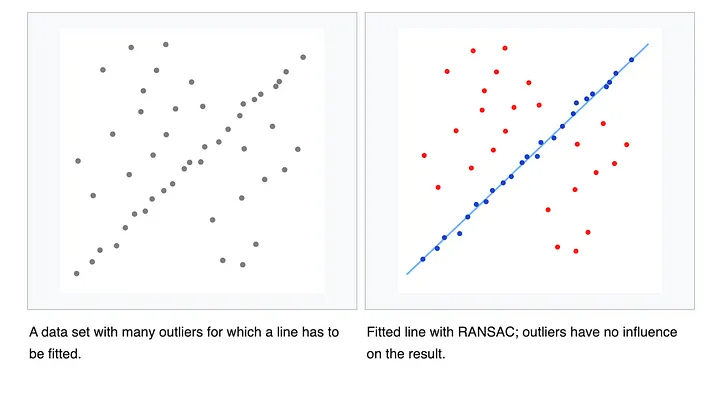

**Then we apply PnP solver on those inliers to get the translation and rotation vector. (refined_rvecs and refined_tvecs)**



The translation and rotation vectors represents the transformation to go from the 3D coordinates to the camera coordinates. The following image from OpenCV documentation represents the coordinates system change from world coordinate system to camera coordinate system, R being the rotation matrix and t the translation matrix. (ui,vi) points are 2D keypoints, and ci points are the 3D model of our satellite. R change the orientation of the coordinate system, and t change the position of the coordinate sysmem's origin.

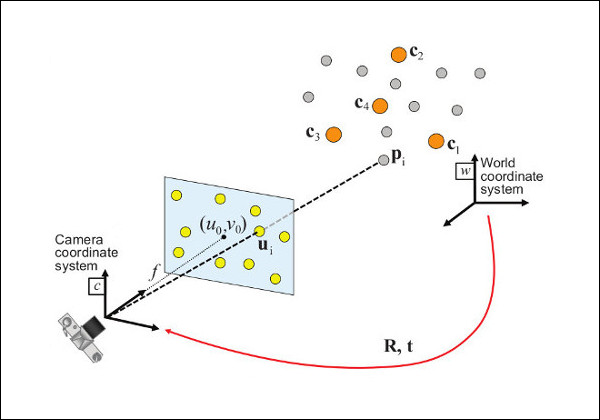




The world coordinates system's origin being at the center of the satellite, **refined_rvecs is the position of the satellite in the camera's point of view, and refined_tvecs is the orientation of the satellite in the camera's point of view.**


*To understand the mathematics behind PnP and RANSAC, I suggest you read the two references at the end of this notebook.*

To use this pose estimator, you need to :
* Replace key_points by your 3D model of satellite, with the center of the coordinates system of your keypoints being the point on which you want to predict the pose.
* Replace camera_matrix and dist_coeffs by the parameters of your camera.
* Run refined_rvecs, refined_tvecs = correct_coordinates(key_points_3d, noisy_points_2d, camera_matrix, dist_coeffs) to get the pose. The result is refined_rvecs and  refined_tvecs.

*You can also run the tests to see how it works.*

In [1]:
import numpy as np
import cv2

def pnp_ransac_solve(points_3d, points_2d, camera_matrix, dist_coeffs):
    # Convert input data to OpenCV-compatible format.
    obj_points = np.array([points_3d], dtype=np.float32)
    img_points = np.array([points_2d], dtype=np.float32)
    camera_matrix = np.array(camera_matrix, dtype=np.float32)
    dist_coeffs = np.array(dist_coeffs, dtype=np.float32)

    # Estimate satellite's pose using PnP with RANSAC.
    success, rvecs, tvecs, inliers = cv2.solvePnPRansac(obj_points, img_points, camera_matrix, dist_coeffs)

    if success:
        return rvecs, tvecs, inliers
    else:
        print("PnP with RANSAC failed to converge.")
        return None, None, None

def correct_coordinates(key_points_3d, noisy_points_2d, camera_matrix, dist_coeffs):
    # Estimate satellite's pose with RANSAC.
    rvecs, tvecs, inliers = pnp_ransac_solve(key_points_3d, noisy_points_2d, camera_matrix, dist_coeffs)

    if inliers is not None:
        # Extract inlier points.
        inlier_points_3d = [key_points_3d[i] for i in inliers.ravel()]
        inlier_points_2d = [noisy_points_2d[i] for i in inliers.ravel()]

        # Convert camera matrix and distortion coefficients to numpy arrays.
        camera_matrix = np.array(camera_matrix)
        dist_coeffs = np.array(dist_coeffs)


        # Refine the satellite pose by computing PnP with inliers points only.
        retval, refined_rvecs, refined_tvecs = cv2.solvePnP(np.array(inlier_points_3d), np.array(inlier_points_2d),
                                                     camera_matrix, dist_coeffs,
                                                     flags=cv2.SOLVEPNP_ITERATIVE)

        return refined_rvecs, refined_tvecs
    else:
        print("No inliers found. Unable to refine satellite's pose.")
        return None, None

# 3D model of the keypoints of the satellite
#The center of the satellite is at coordinates [0,0,0]
key_points = [
    {"name": "front_bottom_right", "position": [0.369955, -0.284232, -0.1628385]},
    {"name": "front_bottom_left", "position": [-0.369955, -0.284232, -0.1628385]},
    {"name": "back_bottom_right", "position": [0.369955, -0.284232, -0.1628385]},
    {"name": "back_bottom_left", "position": [-0.369955, 0.284232, -0.1628385]},
    {"name": "front_top_right", "position": [0.37038, -0.362269, 0.1628385]},
    {"name": "front_top_left", "position": [-0.37038, -0.362269, 0.1628385]},
    {"name": "back_top_right", "position": [0.37038, 0.362269, 0.1628385]},
    {"name": "back_top_left", "position": [-0.37038, 0.362269, 0.1628385]},
    {"name": "front_antenna", "position": [0.299655, -0.557408, 0.0958055]},
    {"name": "right_antenna", "position": [0.537382, 0.493957, 0.0958055]},
    {"name": "left_antenna", "position": [-0.537382, 0.493957, 0.0958055]}
]

# Extracting the positions of the key points.
key_points_3d = np.array([point["position"] for point in key_points], dtype=np.float32)

# Example camera parameters (intrinsic matrix and distortion coefficients):
camera_matrix = [[100, 0, 50],
                 [0, 100, 50],
                 [0, 0, 1]]
dist_coeffs = [0, 0, 0, 0]




#Tests

In [2]:
# Example noisy 2D image points of the key points.
import numpy as np

noisy_points_2d = np.array([[  94.11778317,   16.97506375],
                             [  10.23322833,   28.83004612],
                             [  84.44269243,   18.78228161],
                             [   5.87413665,   76.32507395],
                             [ 165.69715222,  -64.99907403],
                             [ -57.50572494,  -62.89163822],
                             [ 162.0545866,   157.56129822],
                             [ -66.52992155,  163.10722524],
                             [ 161.49755104, -162.7983367 ],
                             [ 265.93881961,  243.48218933],
                             [-160.18293575,  238.92412381]], dtype=np.float32)



# Estimate satellite's pose, without being affected by outliers
refined_rvecs, refined_tvecs = correct_coordinates(key_points_3d, noisy_points_2d, camera_matrix, dist_coeffs)

if refined_rvecs is not None:
    print("Refined Rotation Vector:", refined_rvecs.ravel())
    print("Refined Translation Vector:", refined_tvecs.ravel())
else:
    print("Failed to correct coordinates.")

Refined Rotation Vector: [-0.01546752  0.00404841  0.00125181]
Refined Translation Vector: [ 0.00079877 -0.01389702  0.16385272]


#Useful documents

The OpenCV documentation for PnP, if you want to understand the mathematics begind PnP : https://docs.opencv.org/4.x/d5/d1f/calib3d_solvePnP.html

An article that explain RANSAC simply : https://medium.com/@chandu.bathula16/machine-learning-concept-69-random-sample-consensus-ransac-e1ae76e4102a